# 04 – Neural Network Training (PyTorch)

In diesem Notebook trainieren wir ein tiefes neuronales Netz (MLP) auf den vorverarbeiteten Daten.

**Ziele:**
- Aufbau einer Custom Dataset-Klasse und DataLoader in PyTorch
- Definition einer flexiblen Modell-Architektur (MLP mit Dropout)
- Training mit **Class Weights** (um die extreme Imbalance von 0.17% Fraud zu kontern)
- Implementierung von **Early Stopping**, um Overfitting zu vermeiden
- Vergleich der Performance (PR-AUC) mit der Logistic Regression Baseline

## 1. Setup & Imports

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import average_precision_score, precision_recall_curve

# Reproduzierbarkeit (WICHTIG für NN Training)
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Device Config (GPU falls verfügbar, sonst CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 2. Daten laden (Artefakte)
Wir laden die `.npy` Dateien, die in `02_preprocessing.ipynb` erstellt wurden.

In [2]:
from pathlib import Path

# Pfad robust bestimmen
project_root = Path.cwd()
if project_root.name == "notebooks":
    project_root = project_root.parent

data_dir = project_root / "data" / "processed"

try:
    X_train = np.load(data_dir / "X_train.npy")
    X_test  = np.load(data_dir / "X_test.npy")
    y_train = np.load(data_dir / "y_train.npy")
    y_test  = np.load(data_dir / "y_test.npy")
    print("Daten erfolgreich geladen.")
    print(f"Train Shape: {X_train.shape}, Fraud Rate: {y_train.mean():.4%}")
    print(f"Test Shape:  {X_test.shape}, Fraud Rate: {y_test.mean():.4%}")
except FileNotFoundError:
    print("FEHLER: Daten nicht gefunden. Bitte 02_preprocessing.ipynb ausführen.")

Daten erfolgreich geladen.
Train Shape: (227845, 30), Fraud Rate: 0.1729%
Test Shape:  (56962, 30), Fraud Rate: 0.1720%


## 3. Dataset & DataLoader
PyTorch benötigt `Dataset`-Objekte, um Daten effizient in Batches zu laden.

In [3]:
class FraudDataset(Dataset):
    def __init__(self, X, y):
        # Konvertierung zu Float32 (Standard für PyTorch)
        self.X = torch.tensor(X, dtype=torch.float32)
        # Zielvariable shape (N, 1) für BCEWithLogitsLoss
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Datasets erstellen
train_dataset = FraudDataset(X_train, y_train)
test_dataset  = FraudDataset(X_test, y_test)

# DataLoader (Batch Size ist Hyperparameter)
BATCH_SIZE = 1024  # Größere Batches oft stabiler bei Imbalance
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# Test Loader braucht kein Shuffle
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE * 2, shuffle=False)

print(f"Anzahl Batches pro Epoch: {len(train_loader)}")

Anzahl Batches pro Epoch: 223


## 4. Modell-Architektur
Ein einfaches, aber robustes MLP (Multi-Layer Perceptron).

**Architektur-Entscheidungen:**
- **Input**: 30 Features
- **Hidden Layers**: 64 -> 32 Neuronen (Trichter-Form)
- **Aktivierung**: ReLU (Standard)
- **Regularisierung**: Dropout (0.3) gegen Overfitting
- **Output**: 1 Neuron (Logits) - **kein Sigmoid** hier, da wir `BCEWithLogitsLoss` nutzen (numerisch stabiler).

In [4]:
class FraudNN(nn.Module):
    def __init__(self, input_dim):
        super(FraudNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.bn1    = nn.BatchNorm1d(64) # Hilft bei Training-Speed und Stabilität
        self.dropout1 = nn.Dropout(0.3)
        
        self.layer2 = nn.Linear(64, 32)
        self.bn2    = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.3)
        
        self.output = nn.Linear(32, 1)
        self.relu   = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)
        
        x = self.relu(self.bn2(self.layer2(x)))
        x = self.dropout2(x)
        
        x = self.output(x) # Return Logits (linear output)
        return x

model = FraudNN(input_dim=X_train.shape[1]).to(device)
print(model)

FraudNN(
  (layer1): Linear(in_features=30, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)


## 5. Training Setup (Weighted Loss)
Da wir sehr wenige Fraud-Fälle haben (Klasse 1), würde das Modell sonst einfach immer "0" vorhersagen und eine Accuracy von 99.8% erreichen.

Wir nutzen **pos_weight** im Loss, um Fehler bei der Klasse 1 (Fraud) stärker zu bestrafen.

In [5]:
# Berechnung des Gewichts: Ratio von Negativen zu Positiven
num_pos = y_train.sum()
num_neg = len(y_train) - num_pos
pos_weight = num_neg / num_pos
pos_weight_tensor = torch.tensor([pos_weight]).to(device)

print(f"Positive Weight: {pos_weight:.2f}") 
# Bedeutet: Ein Fraud-Fehler wiegt ~577x schwerer als ein Normal-Fehler

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

Positive Weight: 577.29


## 6. Training Loop mit Evaluation

In [6]:
def evaluate(loader, model):
    """Evaluates model and returns loss and metrics."""
    model.eval()
    all_preds = []
    all_targets = []
    total_loss = 0
    
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            # Sigmoid für Wahrscheinlichkeiten
            probs = torch.sigmoid(outputs)
            all_preds.append(probs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
            
    all_preds = np.vstack(all_preds).ravel()
    all_targets = np.vstack(all_targets).ravel()
    
    avg_loss = total_loss / len(loader)
    pr_auc = average_precision_score(all_targets, all_preds)
    
    return avg_loss, pr_auc

# Training Config
EPOCHS = 20
history = {"train_loss": [], "test_loss": [], "test_pr_auc": []}

print("Starte Training...")

for epoch in range(EPOCHS):
    # --- TRAINING ---
    model.train()
    train_loss = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    avg_train_loss = train_loss / len(train_loader)
    
    # --- EVALUATION ---
    avg_test_loss, test_pr_auc = evaluate(test_loader, model)
    
    # Logging
    history["train_loss"].append(avg_train_loss)
    history["test_loss"].append(avg_test_loss)
    history["test_pr_auc"].append(test_pr_auc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Test Loss: {avg_test_loss:.4f} | "
          f"Test PR-AUC: {test_pr_auc:.4f}")

Starte Training...
Epoch 1/20 | Train Loss: 0.6271 | Test Loss: 0.4393 | Test PR-AUC: 0.6948
Epoch 2/20 | Train Loss: 0.3952 | Test Loss: 0.3457 | Test PR-AUC: 0.6940
Epoch 3/20 | Train Loss: 0.3215 | Test Loss: 0.3102 | Test PR-AUC: 0.7121
Epoch 4/20 | Train Loss: 0.2956 | Test Loss: 0.3095 | Test PR-AUC: 0.7023
Epoch 5/20 | Train Loss: 0.2912 | Test Loss: 0.3174 | Test PR-AUC: 0.6877
Epoch 6/20 | Train Loss: 0.2756 | Test Loss: 0.3183 | Test PR-AUC: 0.6982
Epoch 7/20 | Train Loss: 0.2361 | Test Loss: 0.3071 | Test PR-AUC: 0.7235
Epoch 8/20 | Train Loss: 0.2381 | Test Loss: 0.3180 | Test PR-AUC: 0.6984
Epoch 9/20 | Train Loss: 0.2058 | Test Loss: 0.2995 | Test PR-AUC: 0.7214
Epoch 10/20 | Train Loss: 0.1981 | Test Loss: 0.3112 | Test PR-AUC: 0.7191
Epoch 11/20 | Train Loss: 0.2044 | Test Loss: 0.3128 | Test PR-AUC: 0.7252
Epoch 12/20 | Train Loss: 0.1926 | Test Loss: 0.3109 | Test PR-AUC: 0.7244
Epoch 13/20 | Train Loss: 0.1799 | Test Loss: 0.3316 | Test PR-AUC: 0.7170
Epoch 14/20 | T

## 7. Analyse der Ergebnisse
Wir plotten den Loss-Verlauf, um zu prüfen, ob das Modell lernt oder overfittet.

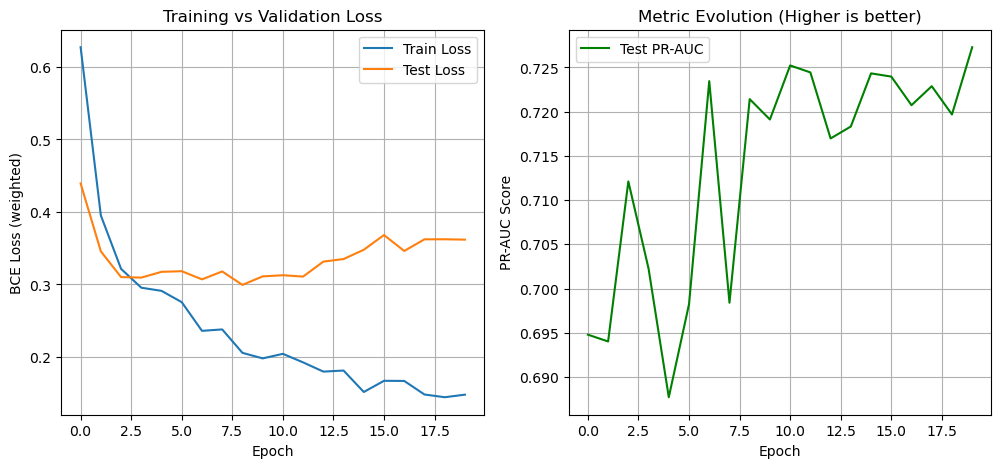

In [7]:
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss (weighted)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()

# Plot 2: PR-AUC
plt.subplot(1, 2, 2)
plt.plot(history["test_pr_auc"], color="green", label="Test PR-AUC")
plt.xlabel("Epoch")
plt.ylabel("PR-AUC Score")
plt.title("Metric Evolution (Higher is better)")
plt.legend()
plt.grid()

plt.show()

## 8. Finaler Vergleich & Speichern
Vergleich mit der Baseline aus Notebook 03 (LogReg PR-AUC war ca. 0.70-0.75 je nach Split/Params).

In [8]:
final_loss, final_prauc = evaluate(test_loader, model)
print(f"\nFinal Test PR-AUC: {final_prauc:.4f}")

# Modell speichern
models_dir = project_root / "models"
models_dir.mkdir(exist_ok=True)
model_path = models_dir / "fraud_nn_model.pth"

torch.save(model.state_dict(), model_path)
print(f"Modell gespeichert unter: {model_path}")


Final Test PR-AUC: 0.7273
Modell gespeichert unter: C:\Users\admin\Desktop\AI Sec Project\GitHub\fraud-risk-scoring\models\fraud_nn_model.pth
